# Dealing with inbalanced Dataset

We have a dataset in realisitc proportion, we could oversemple but it will not be good.

We have a lot of IBD events created by Andrea and also a lot of radioactivity events. If we sort them in temporal order we get that there will be a little amount of IBD in all the radioactivity events, because it is more frequently have radioactivity events respect of IBD that are rare. 

So in order to train our ML-algorithm we could use generated IBD events and generated Radioactivity events, so in that cse we have basically the same amount of data and the inbalanced problem will disappear. After the training, we test with inbalaced dataset.

Basically we use a smote 

We will se if it work...

In [1]:
import uproot as up
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

plt.style.use('seaborn-v0_8-paper')
plt.rcParams["patch.force_edgecolor"] = True

## Imorting datasets
For the dataset we will use -unoscillated_IBD_userfile- and -radioactivity_userfile_7days- for the background.

In [2]:
file_BKG = up.open("radioactivity_userfile_7days.root")
#file_IBD = up.open('../BrutalCuts/unoscillated_IBD_userfile.root') 
file_IBD = up.open('ibd_userfile_1500days_tprecision.root') 


dataset_IBD_all = file_IBD['TRec'].arrays(library = 'np')
dataset_BKG = file_BKG['TRec'].arrays(library = 'np')

dataset_IBD = {}
for key in ['recx', 'recy', 'recz', 'm_QEn', 'm_triggerT']:
    dataset_IBD[key] = dataset_IBD_all[key]

en_fact = 0.92
dataset_IBD["m_QEn"] = dataset_IBD["m_QEn"]*en_fact 

## Cheking temporal order


IBD:  0
BKG: 0
Cutted points:  50310    Total points:  99999


10600

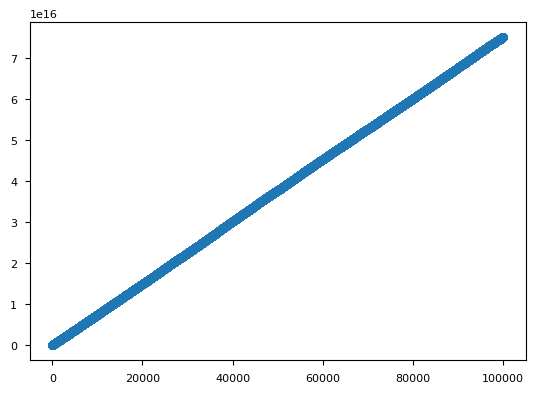

In [3]:
cut = 100000


delta_t_IBD = dataset_IBD['m_triggerT'][1:cut] - dataset_IBD['m_triggerT'][:cut-1]
mask_IBD = np.logical_and(delta_t_IBD < 0, True)

print("IBD: ",mask_IBD.sum())

delta_t_BKG = dataset_BKG['m_triggerT'][1:cut] - dataset_BKG['m_triggerT'][:cut-1]
mask_BKG = np.logical_and(delta_t_BKG < 0, True)

print("BKG:", mask_BKG.sum())

#Plot of IBDs because they are not in temporal order
plt.scatter(np.arange(cut),dataset_IBD['m_triggerT'][:cut])

mask_dt_IBD = np.logical_and(delta_t_IBD > 5*220e3, True)
print("Cutted points: ", mask_dt_IBD.sum(), " ", ' Total points: ', mask_dt_IBD.shape[0])

mask_dt_BKG = np.logical_and(delta_t_BKG < 5*220e3, True)
mask_dt_BKG.sum()


# Creation of two tables of features
One for IBD events and one for BKG, keeping them separately.


The feature table will have those features ($\Delta t$, $\Delta r$, $E_p$, $E_d$,$R_{prompt}$, $R_{delayed}$, $Label$)

In [4]:
from numba import njit, prange

In [5]:
@njit(parallel = True)
def create_features_handle(x,y,z,E,t,expon_time_cut = 5 * 220e3):

    n = x.shape[0] - 1
      
    delta_time = n*[np.zeros(0)]
    delta_radius = n*[np.zeros(0)]
    E_pro = n*[np.zeros(0)]
    E_del = n*[np.zeros(0)] 
    R_prompt = n*[np.zeros(0)]
    R_delayed = n*[np.zeros(0)]

    for i in prange(x.shape[0] - 1):

        mask = np.logical_and(t>t[i], (t - t[i]) < expon_time_cut)
        to_loop = np.nonzero(mask)[0] 

        for t_index in range(len(to_loop)):
            j = to_loop[t_index] 

            if (t[j] - t[i]) < expon_time_cut:
                delta_time[i] = np.append(delta_time[i], t[j] - t[i])
                delta_radius[i] = np.append(delta_radius[i], np.sqrt((x[i] - x[j])**2 + (y[i] - y[j])**2 + (z[i] - z[j])**2))
                E_pro[i] = np.append(E_pro[i], E[i])
                E_del[i] = np.append(E_del[i], E[j])
                R_prompt[i] = np.append(R_prompt[i],np.sqrt((x[i])**2 + (y[i])**2 + (z[i])**2))
                R_delayed[i] = np.append(R_delayed[i],np.sqrt((x[j])**2 + (y[j])**2 + (z[j])**2))

            else:
                print(i, j, t[j] - t[i], 'Qualcosa non va')
                break

    return delta_time, delta_radius, E_pro, E_del, R_prompt, R_delayed

from iteration_utilities import deepflatten

# Funzione per fare un flatten dell'output di Numba
def create_features(x,y,z,E,t, expon_time_cut = 5 * 220e3):
    res = create_features_handle(x,y,z,E,t, expon_time_cut)
    out = []
    for vec in res:
        out.append(np.asarray(list(deepflatten(vec))))  
    return out

## For IBD events

In [6]:
features_IBD = {"delta_time": np.array([]), #Questa è vuota 
            "delta_radius": np.array([]),
            "E_pro": np.array([]),
            "E_del": np.array([]),
            "R_prompt": np.array([]),
            "R_delayed": np.array([])} 

cut = 100000
features_IBD["delta_time"],features_IBD["delta_radius"],features_IBD["E_pro"],features_IBD["E_del"],features_IBD["R_prompt"],features_IBD["R_delayed"]  = create_features(
    dataset_IBD["recx"][:cut],
    dataset_IBD["recy"][:cut],
    dataset_IBD["recz"][:cut],
    dataset_IBD["m_QEn"][:cut],
    dataset_IBD["m_triggerT"][:cut])




In [7]:
print(features_IBD["delta_time"].shape[0])
print(features_IBD["delta_radius"].shape[0])
print(features_IBD["E_pro"].shape[0])
print(features_IBD["E_del"].shape[0])
print(features_IBD["R_prompt"].shape[0])
print(features_IBD["R_delayed"].shape[0])

49689
49689
49689
49689
49689
49689


Ne sono 47mila eprchè a casua dell'exponential time cut, priaticamente tra tutte le coppie possibili per l'IBD viene selzionata quasi sempre l'evento i-esimo e il successivo.
Alcune volte non viene selezionato proprio nulla.

## For the BKG events

In [8]:
features_BKG = {"delta_time": np.array([]),
                "delta_radius": np.array([]),
                "E_pro": np.array([]),
                "E_del": np.array([]),
                "R_prompt": np.array([]),
                "R_delayed": np.array([])}

cut = 100000

features_BKG["delta_time"],features_BKG["delta_radius"],features_BKG["E_pro"],features_BKG["E_del"],features_BKG["R_prompt"],features_BKG["R_delayed"] = create_features(
        dataset_BKG["recx"][:cut],
        dataset_BKG["recy"][:cut],
        dataset_BKG["recz"][:cut],
        dataset_BKG["m_QEn"][:cut],
        dataset_BKG["m_triggerT"][:cut])

In [9]:
print(features_BKG["delta_time"].shape[0])
print(features_BKG["delta_radius"].shape[0])
print(features_BKG["E_pro"].shape[0])
print(features_BKG["E_del"].shape[0])
print(features_BKG["R_prompt"].shape[0])
print(features_BKG["R_delayed"].shape[0])

11237
11237
11237
11237
11237
11237


## Plots before the cut

Delta time

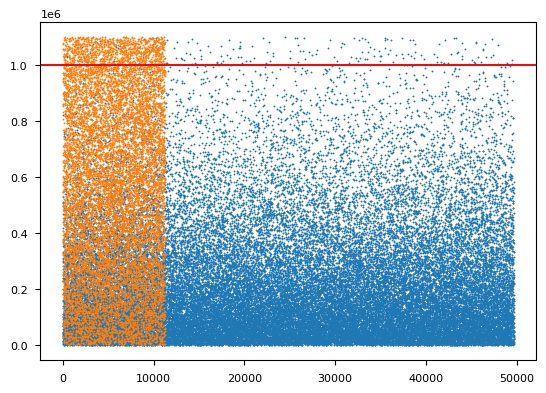

In [10]:
plt.scatter(np.arange(features_IBD["delta_time"].shape[0]), features_IBD["delta_time"], s=1)
plt.scatter(np.arange(features_BKG["delta_time"].shape[0]), features_BKG["delta_time"], s=1)
plt.axhline(1e6, c = 'red')

Delta radius

Ne perdiamo:  0


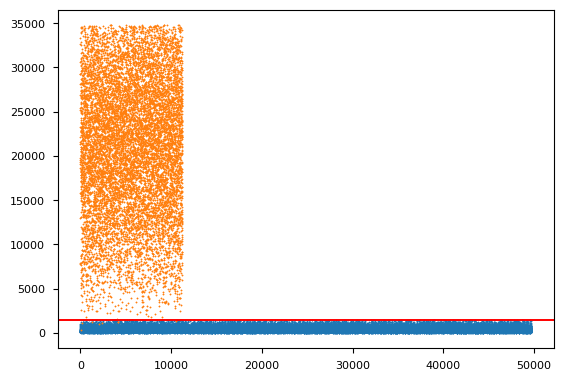

In [11]:
plt.scatter(np.arange(features_IBD["delta_radius"].shape[0]), features_IBD["delta_radius"], s=1)
plt.scatter(np.arange(features_BKG["delta_radius"].shape[0]), features_BKG["delta_radius"], s=1)

count = np.logical_and(True, features_IBD["delta_radius"]>1500)
print("Ne perdiamo: ", count.sum())
plt.axhline(1500, c = 'red')

## Cutting algorithm for BOTH IBD and BKG

In [12]:
@njit(parallel = True) 
#delta time in nanoseconds
#delta radius in mm
def selection(dt,dr,E_pro,E_del, delta_time = 1e6, delta_radius = 1500, min_energy_prompt = 0.7,max_energy_prompt = 12, min_energy_delay = 1.9, max_energy_delay = 2.5, min_energy_delay_carb = 4.4, max_energy_delay_carb = 5.5):
    prompt_columns = np.zeros(dt.shape)
    delay_columns = np.zeros(dt.shape)
    delay_columns_carb = np.zeros(dt.shape)
    for i in prange(dt.shape[0]):
        if dt[i] < delta_time: #It is not necessery
            if dr[i] < delta_radius: 
                if E_pro[i]>= min_energy_prompt and E_pro[i]<= max_energy_prompt:
                    if E_del[i]>= min_energy_delay and E_del[i]<= max_energy_delay:
                        prompt_columns[i] = 1
                        delay_columns[i] = 1
                    if E_del[i]>= min_energy_delay_carb and E_del[i]<= max_energy_delay_carb:
                        prompt_columns[i] = 1
                        delay_columns_carb[i] = 1
    return prompt_columns,delay_columns,delay_columns_carb

### IBD selection

In [13]:
prompt_columns_IBD, delay_columns_IBD, delay_columns_carb_IBD = selection(features_IBD["delta_time"],
                                                                           features_IBD["delta_radius"],
                                                                           features_IBD["E_pro"],
                                                                           features_IBD["E_del"])

In [14]:
print(prompt_columns_IBD.sum(), prompt_columns_IBD.shape[0])
print(delay_columns_carb_IBD.sum(),delay_columns_carb_IBD.shape[0])
print(delay_columns_IBD.sum(),delay_columns_IBD.shape[0])



print("Accuracy: ", ((prompt_columns_IBD.sum() + delay_columns_carb_IBD.sum() + delay_columns_IBD.sum())  / (prompt_columns_IBD.shape[0] * 2)) * 100)

49113.0 49689
563.0 49689
48550.0 49689
Accuracy:  98.84078971200869


### BKG selection

In [15]:
prompt_columns_BKG, delay_columns_BKG, delay_columns_carb_BKG = selection(features_BKG["delta_time"],
                                                                           features_BKG["delta_radius"],
                                                                           features_BKG["E_pro"],
                                                                           features_BKG["E_del"])

In [16]:
print(prompt_columns_BKG.sum(), prompt_columns_BKG.shape[0])
print(delay_columns_carb_BKG.sum(),delay_columns_carb_BKG.shape[0])
print(delay_columns_BKG.sum(),delay_columns_BKG.shape[0])



print("Accuracy: ", 1 - ((prompt_columns_BKG.sum() + delay_columns_carb_BKG.sum() + delay_columns_BKG.sum())  / (prompt_columns_BKG.shape[0] * 2)) * 100)

1.0 11237
0.0 11237
1.0 11237
Accuracy:  0.9911008276230311


### Plots after the cuts

(array([  0.,   0.,   1.,   1.,   1.,  23.,  58., 142., 189., 110.,  32.,
          5.,   1.]),
 array([4.4       , 4.48461538, 4.56923077, 4.65384615, 4.73846154,
        4.82307692, 4.90769231, 4.99230769, 5.07692308, 5.16153846,
        5.24615385, 5.33076923, 5.41538462, 5.5       ]),
 <BarContainer object of 13 artists>)

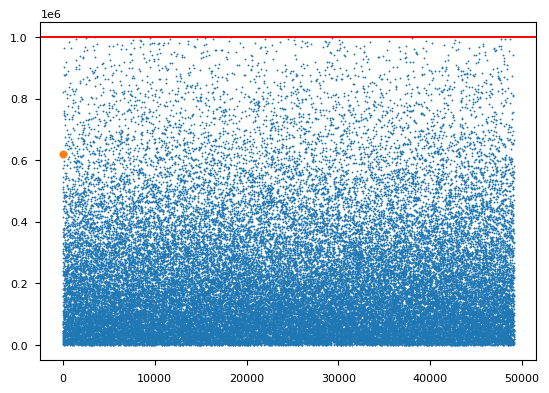

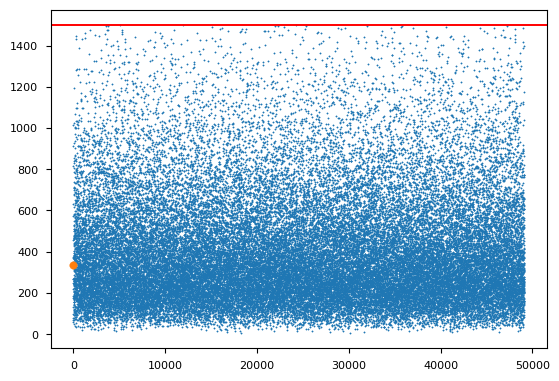

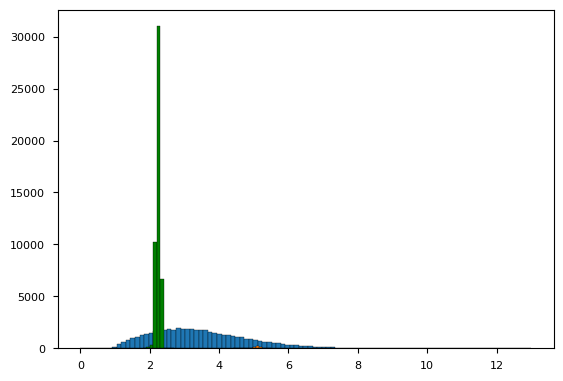

In [17]:
fig1 = plt.figure()
plt.scatter(np.arange(prompt_columns_IBD.sum()), features_IBD["delta_time"][prompt_columns_IBD == 1], s=1)
plt.scatter(np.arange(prompt_columns_BKG.sum()), features_BKG["delta_time"][prompt_columns_BKG == 1], s=30)
plt.axhline(1e6, c = 'red')

fig2 = plt.figure()
plt.scatter(np.arange(prompt_columns_IBD.sum()), features_IBD["delta_radius"][prompt_columns_IBD == 1], s=1)
plt.scatter(np.arange(prompt_columns_BKG.sum()), features_BKG["delta_radius"][prompt_columns_BKG == 1], s=30)
plt.axhline(1500, c = 'red')

fig3 = plt.figure()
plt.hist(features_IBD["E_pro"][prompt_columns_IBD == 1], np.linspace(0,13,100))
plt.hist(features_IBD["E_del"][delay_columns_IBD == 1], np.linspace(1.8,2.7,10), color= "green")
plt.hist(features_IBD["E_del"][delay_columns_carb_IBD == 1], np.linspace(4.4,5.5,14))

### Merging the IBD and BKG tables, but the tables before the cuts 

In [18]:
def combine_dict(d1, d2):
    combined = {}
    for k in set(d1.keys()) | set(d2.keys()):
        if k in d1 and k in d2 and isinstance(d1[k], np.ndarray) and isinstance(d2[k], np.ndarray):
            combined[k] = np.concatenate([d1[k], d2[k]])
        elif k in d1:
            combined[k] = d1[k]
        else:
            combined[k] = d2[k]
    
    label = np.concatenate([np.full_like(d1.get(k, []), 1), np.full_like(d2.get(k, []), 0)])
    return {**combined, 'Label': label}

In [21]:
all_feature = combine_dict(features_IBD,features_BKG)
print(all_feature)

{'delta_time': array([ 332599.,  529217.,  367325., ...,    2000.,  961508., 1083151.]), 'E_pro': array([2.28723383, 5.28124189, 5.3664999 , ..., 0.16010985, 1.91592062,
       0.22029625]), 'R_delayed': array([16664.08203125, 16167.33496094, 15071.50683594, ...,
       17399.        , 16078.75976562, 14418.36621094]), 'delta_radius': array([ 1015.95275879,    58.07221603,   369.15115356, ...,
        6528.97900391, 20547.859375  , 23925.40820312]), 'E_del': array([2.19753385, 2.30674553, 2.24862695, ..., 0.51890534, 0.27365047,
       0.15605544]), 'R_prompt': array([17318.61523438, 16185.61621094, 15036.12988281, ...,
       15486.35742188, 17399.        , 14068.36425781]), 'Label': array([1., 1., 1., ..., 0., 0., 0.])}


### Shuffle in random order

In [22]:
# ottieni il numero di righe in ogni array
n_rows = all_feature['E_del'].shape[0]

# crea un nuovo ordine casuale degli indici delle righe
new_order = np.random.permutation(n_rows)

# estrai le righe nei nuovi indici
for key in all_feature:
    all_feature[key] = all_feature[key][new_order]


In [23]:

print(all_feature)
print(all_feature['Label'].sum())

{'delta_time': array([665854.,  45528.,  35144., ...,  61008., 153060.,  29820.]), 'E_pro': array([3.20744729, 1.68112886, 2.09473705, ..., 4.9223547 , 2.05901742,
       3.75058675]), 'R_delayed': array([15121.34082031, 10644.96386719, 15796.56933594, ...,
       12143.70703125, 15039.58300781,  4826.00439453]), 'delta_radius': array([204.83543396, 208.30458069, 277.02484131, ..., 597.40515137,
       413.48840332, 617.86071777]), 'E_del': array([2.19953632, 2.22653198, 2.29176879, ..., 2.18303442, 2.18715096,
       2.17762518]), 'R_prompt': array([15142.02636719, 10778.73730469, 15873.99023438, ...,
       12398.19433594, 14775.26660156,  4488.64501953]), 'Label': array([1., 1., 1., ..., 1., 1., 1.])}
49689.0


Now some statistics about the data

In [24]:
import pandas as pd

In [25]:
dataframe = pd.DataFrame({k:list(v) for k,v in all_feature.items()})

In [26]:
dataframe.describe()

,delta_time,E_pro,R_delayed,delta_radius,E_del,R_prompt,Label
count,6.092600e+04,60926.000000,60926.000000,60926.000000,60926.000000,60926.000000,60926.000000
mean,2.729670e+05,2.986057,13586.642625,4171.672652,1.999775,13583.001660,0.815563
std,2.606689e+05,1.742799,3476.687040,8557.609276,0.936688,3483.367736,0.387843
min,8.000000e+00,0.005392,77.349991,5.408258,0.010977,209.693619,0.000000
25%,7.493550e+04,1.813791,11441.550781,235.600590,2.167725,11426.215088,1.000000
50%,1.845105e+05,2.908697,14424.317383,403.773499,2.227905,14422.461914,1.000000
75%,3.910200e+05,4.057240,16559.445801,815.420258,2.271519,16570.544434,1.000000
max,1.099757e+06,100.002769,17400.000000,34794.757812,147.998199,17400.001953,1.000000


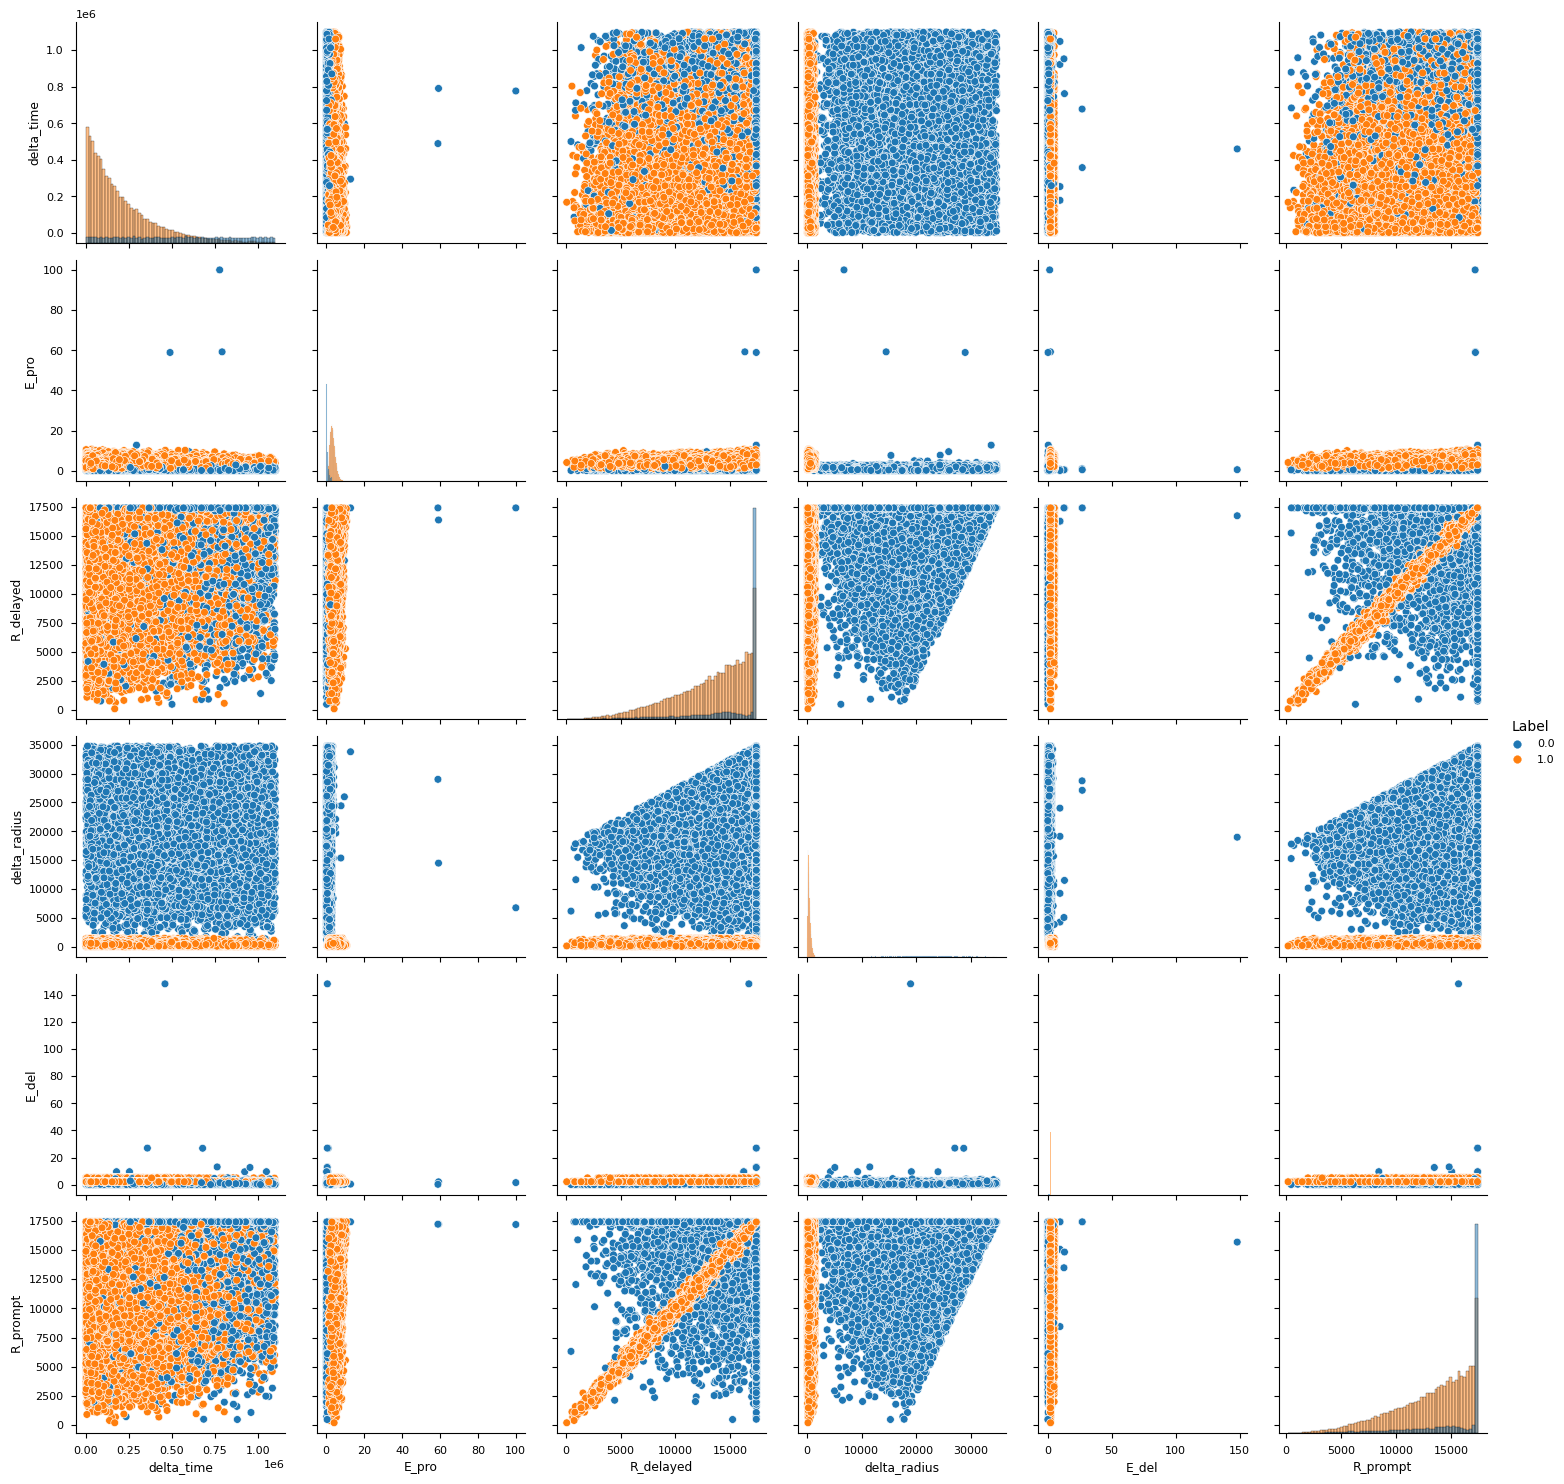

In [27]:
import seaborn as sns


g = sns.PairGrid(dataframe, hue="Label")
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)
g.add_legend()



# Experimenting

## Cut Algorithm 

In [ ]:
prompt_columns, delay_columns, delay_columns_carb = selection(all_feature["delta_time"],
                                                              all_feature["delta_radius"],
                                                              all_feature["E_pro"],
                                                              all_feature["E_del"])

In [ ]:
TP = np.logical_and(all_feature['Label'] == 1, prompt_columns == 1)
TN = np.logical_and(all_feature['Label'] == 0, prompt_columns == 0)
FN = np.logical_and(all_feature["Label"] == 1, prompt_columns == 0)
FP = np.logical_and(all_feature["Label"] == 0, prompt_columns == 1) 

print(((TP.sum()+TN.sum())/(TP.sum()+TN.sum()+FN.sum()+FN.sum())) * 100)
print(all_feature["Label"].sum())
print(prompt_columns.sum())

98.76201518494969
41907.0
41577.0


## XGBClassifier

In [ ]:
all_feature.keys()

dict_keys(['delta_radius', 'R_prompt', 'R_delayed', 'delta_time', 'E_del', 'E_pro', 'Label'])

In [28]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X = np.concatenate((all_feature['delta_time'], all_feature['E_del'], all_feature['E_pro'], all_feature['R_delayed'], all_feature['R_prompt'], all_feature['delta_radius']), axis=0).reshape(-1,6)
Y = all_feature['Label'].reshape(-1,1)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=.2)


# Lista dei nomi delle features
feature_names = list(all_feature.keys())
feature_names.pop()

# Creazione oggetto DMatrix per i dati di addestramento e di test
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=feature_names)
dtest = xgb.DMatrix(X_test, label=y_test, feature_names=feature_names)

#use XGboost to select better features
from xgboost import XGBClassifier
from xgboost import plot_importance
from matplotlib import pyplot

model = XGBClassifier()
model.fit(X_train, y_train) 

# use feature importance for feature selection
from numpy import sort
from sklearn.feature_selection import SelectFromModel

# Fit model using each importance as a threshold
thresholds = sort(model.feature_importances_)
for thresh in thresholds:
    # select features using threshold
    selection = SelectFromModel(model, threshold=thresh, prefit=True)
    select_X_train = selection.transform(X_train)
    # train model
    selection_model = XGBClassifier()
    selection_model.fit(select_X_train, y_train)
    # eval model
    select_X_test = selection.transform(X_test)
    y_pred = selection_model.predict(select_X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (thresh, select_X_train.shape[1], accuracy*100.0))


Thresh=0.160, n=6, Accuracy: 81.59%
Thresh=0.160, n=5, Accuracy: 81.63%
Thresh=0.165, n=4, Accuracy: 81.59%
Thresh=0.170, n=3, Accuracy: 81.63%
Thresh=0.172, n=2, Accuracy: 81.60%
Thresh=0.173, n=1, Accuracy: 81.69%


Il codice utilizza il metodo SHAP in combinazione con  XGBoost. Nello specifico, SHAP utilizza il metodo Tree SHAP per spiegare le predizioni dell'algoritmo XGBoost, ovvero valuta il contributo di ogni variabile in ogni nodo dell'albero di decisione utilizzato da XGBoost per la predizione.

 98%|===================| 11954/12186 [00:19<00:00]        No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


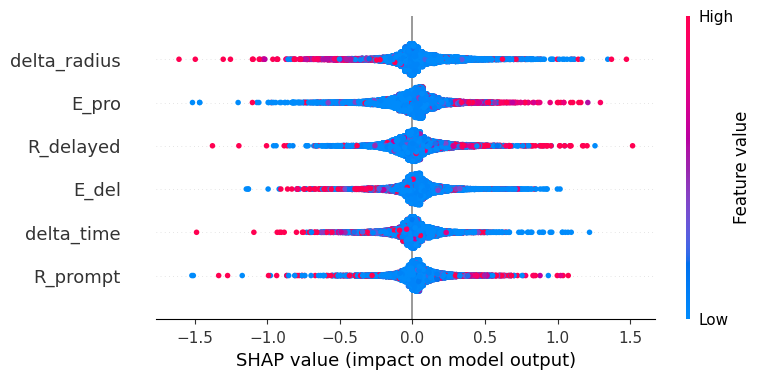

In [29]:
import shap

# Creo un oggetto explainer SHAP
explainer = shap.Explainer(model, X_train)

# Calcolo i valori di Shapley per il set di test
shap_values = explainer(X_test)

# Plotto il summary plot di SHAP
shap.summary_plot(shap_values, X_test, feature_names=feature_names)

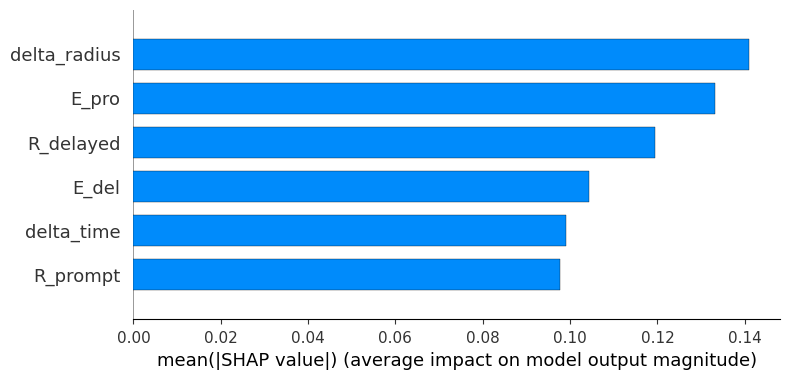

In [30]:
# Importnce plot
shap.summary_plot(shap_values, X_test, feature_names=feature_names , plot_type="bar")


## PyTorch Neural Network

Net(
  (fc1): Linear(in_features=6, out_features=30, bias=True)
  (fc2): Linear(in_features=30, out_features=30, bias=True)
  (fc3): Linear(in_features=30, out_features=2, bias=True)
)

















































































































































































































































































































































































































































































































































































































































































































































































































































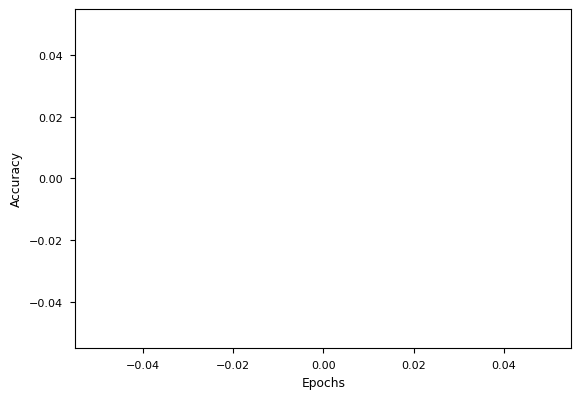

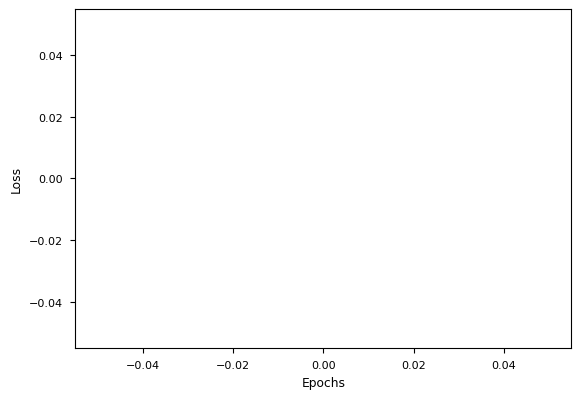

In [32]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class Net(nn.Module):
        
        def __init__(self):
            super().__init__()
            self.fc1 = nn.Linear(6, 30)
            self.fc2 = nn.Linear(30, 30)
            self.fc3 = nn.Linear(30, 2)
            
        def forward(self, x):
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc2(x))
            return F.softmax(self.fc3(x), dim=1)
        
net = Net()
print(net)

#Define the loss function and the optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

#Train the network
for epoch in range(10):
     
    running_loss = 0.0
    for i in range(0, len(X_train), 4):
        # get the inputs; data is a list of [inputs, labels]
        inputs = torch.Tensor(X_train[i:i+4])
        print()
        labels = torch.LongTensor(y_train[i:i+4]) #Creando mini-batches di 4 elementi, il tensore delle labels ha dimensione 4x1
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels.reshape(-1))
        loss.backward()
        optimizer.step()
        
        # print statistics
        running_loss += loss.item()
        if i % 1000 == 999:    # print every 1000 mini-batches
            print('[%d, %5d] loss: %.3f' %(epoch + 1, i + 1, running_loss / 1000))
            running_loss = 0.0

print('Finished Training')

#Test the network
correct = 0
total = 0
with torch.no_grad():
    for i in range(0, len(X_test), 4):
        inputs = torch.Tensor(X_test[i:i+4])
        labels = torch.LongTensor(y_test[i:i+4])
        outputs = net(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels.reshape(-1)).sum().item()

print('Accuracy of the network on the 10000: %d %%' % (100 * correct / total))

#Save the model
PATH = './xgboost_net.pth'
torch.save(net.state_dict(), PATH)

#Load the model
net = Net()
net.load_state_dict(torch.load(PATH))




# TODO list

[ v ] Create two distinct features' tables (one for 100.000 unoscillated IBDs, one for the 7days radioactivity dataset). Remember to add R_ptompt and R_delayed to the stored features


[ v ] Run your standard selection on the two tables separately to estimate efficiency and purity.


[ v ] Remember to remove the "label == 1" from your function.


[ v ] Concatenate the two tables, shuffle the order of the rows and start experimenting. Check the performances of XGBoost compared to the standard selection.

For any problem, write us and we can discuss about it! Have a nice weekend